In [2]:
import os
import http
import re
import sys
import csv
import math#import lightkurve as lk
from lightkurve import search_tesscut
from lightkurve import DesignMatrix
from lightkurve import DesignMatrixCollection
from lightkurve import RegressionCorrector
from lightkurve import LightCurve
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import patches
from astroquery.skyview import SkyView
from astropy.coordinates import get_icrs_coordinates
from astropy.coordinates.name_resolve import NameResolveError
from astroquery.simbad import Simbad
from numpy.linalg import LinAlgError
from astropy.coordinates import SkyCoord
from astropy.wcs import *
from astropy import units as u
from astropy.table import Table
import astropy.io.fits as pyfits
from io import StringIO
sys.setrecursionlimit(10000)
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
#warnings.filterwarnings("error")
plt.ion()
#input_coord_split = re.split(r"\s+|,|\s*,\s*", input_coord_string)
#print("dusted")

primary_correction_method = 3
tpf_width_height = 30
additive_pca_num = 3
multiplicative_pca_num = 3
pca_only_num = 3
lowest_dss_contour = 0.5 
sys_threshold_orig = 0.2
max_masked_regions = 30
#plot_index_init = 300
plot_index_fraction = 0.3
bf_threshold = 1.5 
prop_error_flag = True

#vvv
#aperture
pixel_threshold_orig = 2.2 #times the background flux (for background_percentile = 10, 2.4 for 20?)
int_pixel_threshold_orig = 2.5 #same but for integrated flux instead of at plot_index
background_percentile_orig = 10 #percentile determining background for pixel threshold
decrease_pixel_threshold = 0.05 #reduce pixel threshold by this if central pixel is already below threshold
decrease_int_pixel_threshold = 0.05 #same for integrated flux
shift_plot_index = 50 #shift index by this if there are zero or negative flux values
endlength_fraction = 0.1 #only shift plot index to this fraction of time indices since systematics might occur
adjacent_ratio_threshold = 1.5 #ratio of bridge pixel flux to adjacent pixel flux, rejected if higher
fraction_of_central = 1/2 #for gradients in galaxy: include pixels with adjacent pixel above this fraction
max_aperture_fraction = 1/3 #maximum fraction of the tpf that can be part of the aperture
tpf_size_large = 50 #new tpf_width_height if aperture has too many pixels
tpf_size_huge = 99 #next tpf_width_height if aperture still has too many pixels
shift_background_percentile = 5 #shift background percentile by this if threshold is negative
max_background_percentile = 20 #maximum allowed percentile for background
extension_threshold = 9 #minimum aperture to reject single-pixel width extensions
sys_fractions = [0.0362, 0.380, 0.6216, 0.8802]

#mask
#maskout_threshold = 20 #times the mean absolute value of the additive component
#maskend_threshold = 0.8 #fraction of sys_threshold determining end of a mask
min_bkg_length = 2/3 #acceptable unmasked fraction of the background before starting with new sys_threshold
increase_sys_threshold= 0.05 #increase sys_threshold by this when too much was masked out
min_mask_gap = 10 #gaps smaller than this between values above sys_threshold are included in masks
maskextension = 2 #number of timesteps added before and after each mask
spiky_width = 3 #maximum width of spiky systematics for findspiky
sys_onestep = 0.1 #mask out if sudden jump in principal component is at least this high
maskwidth_jump = 3 #mask out at most this many extra steps before/after a sudden jump
min_tpf_length = 0.5 #maximum fraction of the tpf that can be rejected due to nans or all zeros

#light curve cleaning
#percent = 0.1
#stddevs = 3.5
mdfm_distance = 8 #times mdfm to define threshold for systematics
min_day_between_sys = 0.75 #minimum time between systematics to not be removed
buffer_hours = 3 #hours cut before/after systematics
sys_percentile = 10 #percentile at either end not used for median & mdfm/std
outlier_time = 1 #minimum time between single-cadence outliers to prevent removal
outlier_factor = 1.5 #maximum extra factor for statistical outliers to prevent removal
cut_downlink = 2.5 #cut time in days at either end of downlink
cut_orbit = 1.5 #after beginning / before end of orbit at the edges of the lc
cut_downlink_extra = 0 #for extra downlinks at apogee from cycle 5 on
methods = ['full_hybrid','simple_hybrid','PCA']
#^^^


#vvv
#new flood fill including rejecting bridge pixels
def flood_fill_bridge(x, y, visited, row_col_coords_init, threshold, pixel_threshold, central):
    if len(row_col_coords_init) == 0 and tpf.flux[plot_index].value[x][x] < threshold:
        pixel_threshold += -decrease_pixel_threshold
        threshold = background_flux * pixel_threshold
        #print('flux of central pixel is too low, no aperture mask selected')
        print('flux of central pixel is too low, set new pixel threshold to',pixel_threshold)
        flood_fill_bridge(x, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
    elif (0 <= x < len(visited[0])
        and 0 <= y < len(visited)
        and not visited[y][x]
        and tpf.flux[plot_index].value[y][x] > threshold):
        # Calculate the direction from the central pixel to the current pixel
        direction_x = x - central
        direction_y = y - central
        # Calculate the adjacent pixel coordinates in the direction of the central pixel
        adj_x = x - (0 if abs(direction_x) < abs(direction_y) else 1 if direction_x > 0 else -1 if direction_x < 0 else 0)
        adj_y = y - (0 if abs(direction_y) < abs(direction_x) else 1 if direction_y > 0 else -1 if direction_y < 0 else 0)
        # Check if the adjacent pixel is within bounds
        if 0 <= adj_x < len(visited[0]) and 0 <= adj_y < len(visited): #take care of edge pixels later
            if x == central and y == central:
                visited[y][x] = True
            # Check if the current pixel's flux is not more than 1 sigma higher than the adjacent pixel's flux
            #if tpf[y, x] <= tpf[adj_y, adj_x] + sigma or tpf[adj_y, adj_x] >= tpf[central, central] - sigma:
            if (visited[adj_y][adj_x]
                and ( tpf.flux[plot_index].value[y][x] <=  tpf.flux[plot_index].value[adj_y][adj_x] * adjacent_ratio_threshold
                or tpf.flux[plot_index].value[adj_y][adj_x] >= tpf.flux[plot_index].value[central][central] * fraction_of_central)):
                visited[y][x] = True
                #print('included (',y,',',x,') with flux',tpf[y,x],'compared to (',adj_y,',',adj_x,') with flux',tpf[adj_y,adj_x])
                row_col_coords_init.append((x, y))
                # Recursively check neighbouring pixels
                flood_fill_bridge(x + 1, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
                flood_fill_bridge(x - 1, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
                flood_fill_bridge(x, y + 1, visited, row_col_coords_init, threshold, pixel_threshold, central)
                flood_fill_bridge(x, y - 1, visited, row_col_coords_init, threshold, pixel_threshold, central)
                
#same as flood_fill_bridge, but for integrated flux values
def flood_fill_integrated(x, y, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central):
    if len(row_col_coords_init) == 0 and integrated_flux[x][x] < int_threshold:
        """int_pixel_threshold += -decrease_int_pixel_threshold
        int_threshold = int_background_flux * int_pixel_threshold
        #print('flux of central pixel is too low, no aperture mask selected')
        print('flux of central pixel is too low (',integrated_flux[x][x],'<',int_threshold,'), set new integrated pixel threshold to',int_pixel_threshold)
        flood_fill_integrated(x, y, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)"""
        print('flux of central pixel is too low (',integrated_flux[x][x],'<',int_threshold,'), instead try non-integrated flood fill.')
        flood_fill_bridge(x, y, visited, row_col_coords_init, threshold, pixel_threshold, central)
    elif (0 <= x < len(visited[0])
        and 0 <= y < len(visited)
        and not visited[y][x]
        and integrated_flux[y][x] > int_threshold):
        # Calculate the direction from the central pixel to the current pixel
        direction_x = x - central
        direction_y = y - central
        # Calculate the adjacent pixel coordinates in the direction of the central pixel
        adj_x = x - (0 if abs(direction_x) < abs(direction_y) else 1 if direction_x > 0 else -1 if direction_x < 0 else 0)
        adj_y = y - (0 if abs(direction_y) < abs(direction_x) else 1 if direction_y > 0 else -1 if direction_y < 0 else 0)
        # Check if the adjacent pixel is within bounds
        if 0 <= adj_x < len(visited[0]) and 0 <= adj_y < len(visited): #take care of edge pixels later
            if x == central and y == central:
                visited[y][x] = True
            # Check if the current pixel's flux is not more than 1 sigma higher than the adjacent pixel's flux
            #if tpf[y, x] <= tpf[adj_y, adj_x] + sigma or tpf[adj_y, adj_x] >= tpf[central, central] - sigma:
            if (visited[adj_y][adj_x]
                and (integrated_flux[y][x] <=  integrated_flux[adj_y][adj_x] * adjacent_ratio_threshold
                or integrated_flux[adj_y][adj_x] >= integrated_flux[central][central] * fraction_of_central)):
                visited[y][x] = True
                #print('included (',y,',',x,') with flux',tpf[y,x],'compared to (',adj_y,',',adj_x,') with flux',tpf[adj_y,adj_x])
                row_col_coords_init.append((x, y))
                # Recursively check neighbouring pixels
                flood_fill_integrated(x + 1, y, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                flood_fill_integrated(x - 1, y, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                flood_fill_integrated(x, y + 1, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                flood_fill_integrated(x, y - 1, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)

#for aperture mask only around the central object
def flood_fill(x, y, visited, row_col_coords_init, threshold, pixel_threshold):
    if len(row_col_coords_init) == 0 and tpf.flux[plot_index].value[x, x] < threshold:
        pixel_threshold += -decrease_pixel_threshold
        threshold = pixmin * pixel_threshold
        print('flux of central pixel is too low, set new pixel threshold to',pixel_threshold)
        flood_fill(x, y, visited, row_col_coords_init, threshold, pixel_threshold)
    elif (
        0 <= x < len(visited[0])
        and 0 <= y < len(visited)
        and not visited[y][x]
        and tpf.flux[plot_index].value[y, x] > threshold
    ):
        visited[y][x] = True
        row_col_coords_init.append((x, y))
        flood_fill(x + 1, y, visited, row_col_coords_init, threshold, pixel_threshold)
        flood_fill(x - 1, y, visited, row_col_coords_init, threshold, pixel_threshold)
        flood_fill(x, y + 1, visited, row_col_coords_init, threshold, pixel_threshold)
        flood_fill(x, y - 1, visited, row_col_coords_init, threshold, pixel_threshold) 
#        else: print('could not select an aperture')

#fill any gaps (one or pixels wide) in the aperture mask
def flood_fill_gaps(x, y, row_col_coords_init, visited_new):
    if 0 < x < len(visited[0])-1 and 0 < y < len(visited)-1:
        if not visited_new[y][x]:
            if not visited[y][x]: 
                if (visited[y-1][x] and visited[y+1][x]) or (visited[y][x-1] and visited[y][x+1]):
                    row_col_coords_init.append((x, y))
                    #print('added (',y,',',x,')')
                elif 1 < x < len(visited[0])-2 and 1 < y < len(visited)-2:
                    if (visited[y-2][x] and visited[y+1][x]) or \
                        (visited[y-1][x] and visited[y+2][x]) or \
                        (visited[y][x-2] and visited[y][x+1]) or \
                        (visited[y][x-1] and visited[y][x+2]):
                        row_col_coords_init.append((x, y))
            visited_new[y][x] = True
            #print('checked (',x,',',y,')')
            flood_fill_gaps(x + 1, y, row_col_coords_init, visited_new)
            flood_fill_gaps(x - 1, y, row_col_coords_init, visited_new)
            flood_fill_gaps(x, y + 1, row_col_coords_init, visited_new)
            flood_fill_gaps(x, y - 1, row_col_coords_init, visited_new)
        
#for masking out regions, arbitrary threshold
def maskoutonce(bkg): #only goes through bkg once, cannot create masks backward
    mask = []
    if len(bkg) > 0:
#        absum = sum(abs(x) for x in bkg)
#        mean = absum / len(bkg)
#        print('mean:',mean)
        for t, timestep in enumerate(bkg):
            if abs(timestep) > sys_threshold: #mean * 20:
                if len(masked_cadence_limits) > 1:
                    if t > masked_cadence_limits[-1]:
#                if len(masked_cadence_limits) > 1 and t - masked_cadence_limits[-1] < 5:
#                    mask = mask[:-1]
#                    print('popped')
                        mask.append(t-maskextension)
                        break
                else: #indent one further if not allowing multiple masks for same region
                    mask.append(t-maskextension)
#                    print('first exceeding:',timestep,'at t =',t)
                    break
        if len(mask) > 0:
            for z, timestep in enumerate(bkg[mask[0]:], start=mask[0]):
                if abs(timestep) <= sys_threshold * maskend_threshold: #mean * 10:
                    mask.append(z+maskextension-1)
                    break
        if len(mask) == 1:
            mask.append(len(bkg))
#        if len(mask) == 2:
#            bkg[mask[0]:mask[1]] = 0
        if len(mask) == 2: #extend mask if systematics a few steps further
            for y, timestep in enumerate(bkg[mask[1]:mask[1] + min_mask_gap], start=mask[1]): #check for systematics in next timesteps
                if abs(timestep) > sys_threshold:
                    for x, timestep2 in enumerate(bkg[y:], start=y): # +3 each
                        if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                            mask[1] = x+maskextension-1 #change end to end of next mask
                            break
        return mask

def maskout(bkg): #create masks wherever additive_bkg is too high
    mask = []
    if len(bkg) > 0:
        for t, timestep in enumerate(bkg):
            if abs(timestep) > sys_threshold: #mean * 20:
                mask.append(t-maskextension) #beginning of systematics
                break
        if len(mask) > 0:
            for z, timestep in enumerate(bkg[mask[0]+maskextension+1:], start=mask[0]+maskextension+1): # +3 each
                if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                    mask.append(z+maskextension-1) #end of systematics (below sys times maskout threshold)
                    break
        if len(mask) == 2: #extend mask if systematics a few steps further
            for y, timestep in enumerate(bkg[mask[1]:mask[1] + min_mask_gap], start=mask[1]): #check for systematics in next timesteps
                if abs(timestep) > sys_threshold:
                    for x, timestep2 in enumerate(bkg[y:], start=y): # +3 each
                        if abs(timestep) <= sys_threshold: # * maskend_threshold: #mean * 10:
                            mask[1] = x+maskextension-1 #change end to end of next mask
                            break
        if len(mask) == 1: #systematics until the very end
            mask.append(len(bkg))
        #print(mask)
        return mask
    
def maskout_once(bkg): 
    mask = []
    if len(bkg) > 0:
        if abs(bkg[0]) > sys_threshold: #systematics at the beginning
            for t, timestep in enumerate(bkg[1:]):
                if abs(timestep) < sys_threshold:
                    mask.append([0,t+maskextension-1])
                    break 
        for t, timestep in enumerate(bkg[1:],start=1):
            maskregion = []
            if abs(timestep) > sys_threshold and abs(bkg[t-1]) <= sys_threshold:
                maskregion.append(t-maskextension) 
                for z, timestep in enumerate(bkg[t+1:], start=t+1):
                    if abs(timestep) < sys_threshold:
                        maskregion.append(z+maskextension-1)
                        mask.append(maskregion)
                        break
        if len(maskregion) > 0: #systematics until the end
            maskregion.append(len(bkg)-1)
            mask.append(maskregion)     
    delete = []
    if len(mask) > 1: #merge masks that are close together
        for j,i in enumerate(mask[1:]):
            if i[0] - mask[j][1] <= min_mask_gap:
                mask[j][1] = i[1]
                delete.append(j+1)
    mask = [masknr for index, masknr in enumerate(mask) if index not in delete]
    return mask   
    
def findspiky(bkg): #only masks out systematics that are narrow
    mask = []
    if len(bkg) > 0:
        if abs(bkg[0]) > sys_threshold: #spiky systematics at the beginning
            for t, timestep in enumerate(bkg[1:1+spiky_width*cadencefactor]):
                if abs(timestep) < sys_threshold:
                    mask.append([0,t+maskextension-1])
                    break 
        for t, timestep in enumerate(bkg[1:],start=1):
            maskregion = []
            if abs(timestep) > sys_threshold and abs(bkg[t-1]) <= sys_threshold:
                if any(abs(value) < sys_threshold for value in bkg[t+1:t+spiky_width*cadencefactor+1]):
                    maskregion.append(t-maskextension)
                    for z, timestep in enumerate(bkg[t+1:t+1+spiky_width*cadencefactor], start=t+1):
                        if abs(timestep) < sys_threshold: # and 1 <= z-t <= spiky_width*cadencefactor
                            maskregion.append(z+maskextension-1) #end of spiky systematics
                            break
                elif abs(bkg[t-1] - timestep) >= sys_onestep: #sudden jump up in PC
                    maskregion.append(t-maskextension)
                    for z, timestep in enumerate(bkg[t+1:t+1+maskwidth_jump*cadencefactor], start=t+1):
                        if abs(timestep) < sys_threshold:
                            maskregion.append(z+maskextension-1)
                            break
                    else:
                        maskregion.append(t+maskwidth_jump*cadencefactor+maskextension-1)
                mask.append(maskregion)
            if abs(timestep) < sys_threshold and abs(bkg[t-1] - timestep) >= sys_onestep:  #sudden jump down in PC
                maskregion.append(t+maskextension-1)
                for z, timestep in enumerate(reversed(bkg[t-1-maskwidth_jump*cadencefactor:t-1])):
                    if abs(timestep) < sys_threshold:
                        maskregion.insert(0,t-z-maskextension)
                        break
                else:
                    maskregion.insert(0,t-maskwidth_jump*cadencefactor-maskextension)
                mask.append(maskregion)
        if abs(bkg[-1]) > sys_threshold: #spiky systematics until the very end
            for t, timestep in enumerate(reversed(bkg[-1-spiky_width*cadencefactor:-1])):
                if abs(timestep) < sys_threshold:
                    mask.append([len(bkg)-t-maskextension,len(bkg)-1])
                    break            
    if mask:
        mask.sort(key=lambda interval: interval[0])
        merged = [mask[0]]
        for spike in mask:
            previous = merged[-1]
            if spike[0] <= previous[1]+1:
                previous[1] = max(previous[1], spike[1])
            else:
                merged.append(spike)
        mask = merged       
    """for s,spike in enumerate(mask[1:],start=1):
            if spike[0] <= mask[s-1][1]:
                print(mask)
                mask[s-1:s+1] = [[mask[s-1][0],mask[s][1]]]
                print(s)
                print([[mask[s-1][0],mask[s][1]]])"""
    return mask

def findswoopy(bkg):
    mask_swoopy = []
    if len(bkg) > 0:
        i = 0
        while i < len(bkg):
            maskregion = []
            if abs(bkg[i]) > sys_threshold:
                if not any(abs(value) < sys_threshold for value in bkg[i+1:i+spiky_width*cadencefactor+1]):
                    maskregion.append(i)
                    for z, timestep in enumerate(bkg[i+1:], start=i+1):
                        if abs(timestep) < sys_threshold:
                            maskregion.append(z)
                            mask_swoopy.append(maskregion)
                            i = z + 1
                            break
            i += 1
        if len(maskregion) == 1:
            maskregion.append(len(bkg)-1)
            mask_swoopy.append(maskregion)
    return mask_swoopy
#^^^
    
# Define function for stitching the sectors together once corrected:
def lc_stitch(unstitched_lc):
    for j in range(0,len(unstitched_lc)):
        if j!=0:
            sector = str(j+1)
        lc = unstitched_lc[j]
        t = lc[:,0]
        f = lc[:,1]
        err = lc[:,2]
        if j == 0:
            full_lc_time = t
            full_lc_flux = f
            full_lc_err= err
        else:
            first_flux = np.mean(f[:10])
            last_flux = np.mean(full_lc_flux[-10:])
            scale_factor= first_flux - last_flux
            if scale_factor > 0:
                scaled_flux = f - abs(scale_factor)
            if scale_factor < 0:
                scaled_flux = f + abs(scale_factor)
            full_lc_time = np.append(full_lc_time,t)
            full_lc_flux = np.append(full_lc_flux,scaled_flux)
            full_lc_err = np.append(full_lc_err,err)
    return full_lc_time,full_lc_flux,full_lc_err

# Define function to remove single-cadence jumps of greater or lesser than 1% of the flux on either side.
def remove_jumps(t,f,err):
    for i in range(0,1-len(t)):
        if i !=0 and i != len(f)-1 and f[i] > (0.01 * f[i-1]+f[i-1]) and f[i] > (0.01 * f[i+1] + f[i+1]):
            t = np.delete(t,i)
            f = np.delete(f,i)
            err = np.delete(err,i)
    for i in range(0,1-len(t)):
        if i !=0 and i != len(f)-1 and f[i] < (f[i-1] - 0.01 * f[i-1]) and f[i] < (f[i+1]-0.01 * f[i+1]):
            t = np.delete(t,i)
            f = np.delete(f,i)
            err = np.delete(err,i)
    return t,f,err


######## BEGIN MAIN PROGRAM ########
#Define target and obtain DSS image from common name or coordinates.

#vvv
#sys.stdout = original_stdout
print('start')

with open('TESS orbits.txt', 'r') as file:
    reader = csv.reader(file, delimiter='\t') 
    downlinks, starts, ends = [], [], []
    for row in reader:
        downlinks.append(float(row[0]))
        starts.append(float(row[1]))
        ends.append(float(row[2]))
"""with open('TESS extra downlinks.txt', 'r') as file:
    reader = csv.reader(file, delimiter='\t') 
    dls1, dls2 = [], []
    for row in reader:
        dls1.append(float(row[0]))
        dls2.append(float(row[1])) #"""

"""with open('targets/targetlist.txt', 'r') as file:
    lines = file.readlines()"""
lines = ['ESO 361-15']

for i in lines:
        #to save printed outputs to a file
    #original_stdout = sys.stdout 
    """with open('text.txt', 'w') as f:
        sys.stdout = f#"""
    """sys.stdout = StringIO()  # Redirect to a variable
    tee_output = sys.stdout #"""
    target = i.strip()
    target = target.replace("Ã¢â‚¬â€œ", "-")
    target_safename = target.replace(" ","")
    print("\n\nNow investigating target", target,'\n')
    directory = f'quaver_output/{target_safename}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    #sys.stdout = original_stdout
    #sys.stdout = open('quaver_output/'+target_safename+'/'+target_safename+'_info.txt', 'w')
    
    try:
#^^^
        target_coordinates = target
        source_coordinates = get_icrs_coordinates(target)       #this requires that SIMBAD be up and working...
        print(source_coordinates)
        #print("\n")
    except NameResolveError:
        print('\n\n',target,"not found. Move to next object.\n\n")
        #sys.stdout = original_stdout
        continue

    try:
        dss_image = SkyView.get_images(position=source_coordinates,survey='DSS',pixels=str(400))
        wcs_dss = WCS(dss_image[0][0].header)
        dss_pixmin = np.min(dss_image[0][0].data)
        dss_pixmax = np.max(dss_image[0][0].data)
        dss_pixmean = np.mean(dss_image[0][0].data)
        dss_head = dss_image[0][0].header
        dss_ra = dss_head['CRVAL1']
        dss_dec = dss_head['CRVAL2']
    except IndexError:
        dss_image = SkyView.get_images(position=source_coordinates,survey='TESS',pixels=str(400))
        wcs_dss = WCS(dss_image[0][0].header)
        dss_pixmin = np.min(dss_image[0][0].data)
        dss_pixmax = np.max(dss_image[0][0].data)
        dss_pixmean = np.mean(dss_image[0][0].data)
        dss_head = dss_image[0][0].header
        dss_ra = dss_head['CRVAL1']
        dss_dec = dss_head['CRVAL2']
        print('IndexError! Use TESS survey instead of DSS for contours.')

    #Retrieve the available tesscut data for FFI-only targets.
    sector_data = search_tesscut(target_coordinates)
    num_obs_sectors = len(sector_data)
    if num_obs_sectors == 0:
        print("This object has not been observed by TESS.")
        #sys.exit()
        continue

    list_observed_sectors = []
    #list_observed_sectors_in_cycle = []
    #list_sectordata_index_in_cycle = []
    for i in range(0,len(sector_data)):
        sector_number = int(sector_data[i].mission[0][12:14])       #This will need to change, Y2K style, if TESS ever has more than 100 sectors.
        list_observed_sectors.append(sector_number)

#vvv
    list_observed_sectors.sort()
    sectors_cyc1 = [sec for sec in list_observed_sectors if sec <= 13]
    sectors_cyc2 = [sec for sec in list_observed_sectors if 14 <= sec <= 26]
    sectors_cyc3 = [sec for sec in list_observed_sectors if 27 <= sec <= 39]
    sectors_cyc4 = [sec for sec in list_observed_sectors if 40 <= sec <= 55]
    sectors_cyc5 = [sec for sec in list_observed_sectors if 56 <= sec <= 69]
    sectors_cyc6 = [sec for sec in list_observed_sectors if 70 <= sec]
    print('observed sectors for',target.strip(),':',list_observed_sectors)
#^^^

    print('\nstarting analysis')
    #If object is observed by TESS and specified Cycle makes sense, begin aperture selection and extraction!

    #vvv    
    unstitched_lc_pca_cyc1 = []
    unstitched_lc_simple_hyb_cyc1 = []
    unstitched_lc_full_hyb_cyc1 = []
    unstitched_lc_pca_cyc2 = []
    unstitched_lc_simple_hyb_cyc2 = []
    unstitched_lc_full_hyb_cyc2 = []
    unstitched_lc_pca_cyc3 = []
    unstitched_lc_simple_hyb_cyc3 = []
    unstitched_lc_full_hyb_cyc3 = []
    unstitched_lc_pca_cyc4 = []
    unstitched_lc_simple_hyb_cyc4 = []
    unstitched_lc_full_hyb_cyc4 = []
    unstitched_lc_pca_cyc5 = []
    unstitched_lc_simple_hyb_cyc5 = []
    unstitched_lc_full_hyb_cyc5 = []
    unstitched_lc_pca_cyc6 = []
    unstitched_lc_simple_hyb_cyc6 = []
    unstitched_lc_full_hyb_cyc6 = []

    try:
        customSimbad = Simbad()
        customSimbad.add_votable_fields('dimensions')
        result = customSimbad.query_object(target)
        try:
            majaxis = result['GALDIM_MAJAXIS']
            minaxis = result['GALDIM_MINAXIS']
        except KeyError:
            print('KeyError when trying to access diameter')
            diameter = 0
        if (majaxis is None or not isinstance(majaxis[0], (int, float, np.float32))) and (minaxis is None or not isinstance(minaxis[0], (int, float, np.float32))):
            print('no diameter found in Simbad')
            diameter = 0
        elif (majaxis is None or not isinstance(majaxis[0], (int, float, np.float32))) and (minaxis is not None and isinstance(minaxis[0], (int, float, np.float32))):
            diameter = minaxis[0]
            print("diameter = minaxis =", diameter, "'")
        elif (majaxis is not None and isinstance(majaxis[0], (int, float, np.float32))) and (minaxis is None or not isinstance(minaxis[0], (int, float, np.float32))):
            diameter = majaxis[0]
            print("diameter = majaxis =", diameter, "'")
        else:
            diameter = (majaxis[0] + minaxis[0]) / 2
            print('majaxis =',majaxis[0],"' ; minaxis =",minaxis[0],"'")
            print("diameter =", diameter, "'")
    except TypeError:
        print('no diameter found in Simbad')
        diameter = 0 

    if diameter <= 8.8:
        tpf_width_height = 30
    elif diameter <= 15.9:
        tpf_width_height = 50
    elif diameter <= 23.0:
        tpf_width_height = 70
    elif diameter <= 34.2:
        tpf_width_height = 99
    else:
        print('Radius too big!')
        diameter = 0
    central = tpf_width_height // 2
    row_col_coords_diameter = []
    pixels_radius = diameter * 60 / 21.2 / 2
    radius_rounded = math.ceil(pixels_radius)
    for m in range(tpf_width_height):
        for n in range(tpf_width_height):
            distance = math.sqrt((m - central)**2 + (n - central)**2)
            if distance <= radius_rounded:
                row_col_coords_diameter.append((m,n))
    print('size aperture mask from Simbad radius:',len(row_col_coords_diameter),'pixels')

    #sys.stdout = original_stdout
    for current_sector in range(1): #len(list_observed_sectors)):
        try:
    #^^^
            tpf = sector_data[current_sector].download(cutout_size=(tpf_width_height, tpf_width_height)) #gets earliest sector
    #vvv
        except Exception:
            print('\n\nSearchError for',target,': Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI. Move to next object.\n\n')
            #sys.stdout = original_stdout
            continue

        #print(integrated_flux)
        #input('ok')
        plot_index = round(len(tpf.flux) * plot_index_fraction)
        central = tpf_width_height // 2
        if current_sector <= 26:
            cadencefactor = 1
        elif current_sector <= 55:
            cadencefactor = 3
        else:
            cadencefactor = 9
            
        #instead of loop:
        orig_length = len(tpf)
        tpf = tpf[~np.isnan(tpf.flux).any(axis=(1,2)) & ~(tpf.flux == 0).all(axis=(1,2))]
        length = len(tpf)
    #^^^
        sector_number = tpf.get_header()['SECTOR']
        sec = str(sector_number)
        ccd = tpf.get_header()['CCD']
        cam = tpf.get_header()['CAMERA']
    #vvv
        #sys.stdout = open('quaver_output/'+target_safename+'/'+target_safename+'_info_'+sec+'.txt', 'w')
        if length < orig_length * min_tpf_length:
            print('Too many cadences have NaNs or are all zero (',orig_length-length,'of',orig_length,'). Skip this sector.')
            continue
    #^^^
        print("\nGenerating pixel map for sector "+sec+".")

        #Check that this object is actually on silicon and getting data (not always the case just because TESSCut says so).
        #By making a light curve from a dummy aperture of the middle 5x5 square and seeing if its mean flux is zero.
        aper_dummy = np.zeros(tpf[0].shape[1:], dtype=bool) #blank
        aper_dummy[int(tpf_width_height/2-3):int(tpf_width_height/2+3),int(tpf_width_height/2-3):int(tpf_width_height/2+3)] = True
        lc_dummy = tpf.to_lightcurve(aperture_mask=aper_dummy)

        if np.mean(lc_dummy.flux) == 0:
            print("This object is not actually on silicon.")
            #sys.ext()
            #continue
            break
        else:
            hdu = tpf.get_header(ext=2)
            #Get WCS information and flux stats of the TPF image.
            tpf_wcs = WCS(tpf.get_header(ext=2))
            pixmin = np.min(tpf.flux[plot_index]).value
        #vvv
            if orig_length != length:
                print('Removed',orig_length-length,'cadences due to nan values or all zero pixel fluxes.')
            if tpf.flux[plot_index].value[central][central] <= 0:
                while plot_index < length*(1-endlength_fraction):
                    plot_index += shift_plot_index
                    print('Central pixel has zero or negative flux value (',tpf.flux[plot_index].value[central][central],')! Now trying index',plot_index,'.')
                    #print('There are negative or zero flux values (pixmin =',pixmin_init,')! \nNow trying index',plot_index,'.')
                    central_pixel_flux = tpf.flux[plot_index].value[central][central]
                    if central_pixel_flux > 0:
                        print('Flux is',central_pixel_flux,'at plot index',plot_index,'. Use this now.')
                        break
                if central_pixel_flux < 0:
                    #pixmin = np.min(x for x in tpf.flux[plot_index_init] if x > 0).value
                    #print('Could not find index without negative or zero flux values. Instead use smallest nonzero absolute value at index',plot_index_init,'. Resulting aperture might not be reasonable.')   
                    print('Central pixel flux negative at all tested plot indices. Skip this sector.')
                    #continue
                    break #due to insertd while loop
                elif central_pixel_flux == 0:
                    print('Central pixel flux zero at all tested plot indices. Skip this sector.')
                    #continue
                    break
        #^^^
            pixmax = np.max(tpf.flux[plot_index]).value
            pixmean = np.mean(tpf.flux[plot_index]).value
            temp_min = float(pixmin)
            # print(temp_min)
            temp_max = float(1e-3*pixmax+pixmean)
            #temp_max = pixmax
            # print(temp_max)
            #Create a blank boolean array for the aperture, which will turn to TRUE when pixels are selected.
            aper = np.zeros(tpf[0].shape[1:], dtype=bool) #blank
            aper_mod = aper.copy() #For the source aperture
            aper_buffer = aper.copy()    #For the source aperture plus a buffer region to exclude from both additive and mult. regressors
            aper_width = tpf[0].shape[1]

        #vvv
            #threshold = pixmin * pixel_threshold
            central = tpf_width_height // 2
            background_percentile = background_percentile_orig
            pixel_threshold = pixel_threshold_orig
            int_pixel_threshold = int_pixel_threshold_orig

            timelength = tpf.time.value[-1] - tpf.time.value[0]
            sys_times = [tpf.time.value[0] + i * timelength for i in sys_fractions]
            time_indices = []
            for a, b in enumerate(tpf.time[:-2]):
                if any(b.value <= threshold < tpf.time.value[a+1] for threshold in sys_times):
                    time_indices.append(a)
            integrated_flux = np.sum(tpf.flux.value[time_indices[0]:time_indices[1]], axis=0) + np.sum(tpf.flux.value[time_indices[2]:time_indices[3]], axis=0) #'''
            #integrated_flux = np.sum(tpf.flux.value, axis=0)
                #sometimes better to use tpf.flux[plot_index].value instead of background_flux?

            background_flux = np.nanpercentile(tpf.flux[plot_index].value, background_percentile)
            int_background_flux = np.nanpercentile(integrated_flux, background_percentile)
            
            flux_flat = np.array(tpf.flux.value).flatten()
            integrated_flux_flat = np.array(integrated_flux).flatten()
            flux_nans = np.isnan(flux_flat).sum()
            int_flux_nans = np.isnan(integrated_flux_flat).sum()
            if flux_nans > 0 or int_flux_nans > 0:
                print('nan values in background!')
                print(flux_nans,'in background flux,',int_flux_nans,'in integrated background flux')
                if int_flux_nans >= tpf_width_height**2*background_percentile/100:
                    print('That is too many! Skip this sector.')
                    break
                    
            threshold = background_flux * pixel_threshold
            int_threshold = int_background_flux * int_pixel_threshold
            if threshold <= 0 or int_threshold <= 0:
                while background_percentile <= max_background_percentile:
                    print('Negative threshold! Background flux =',background_flux,', integrated background flux =',int_background_flux)
                    print('Try with background_percentile =',background_percentile)
                    background_flux = np.nanpercentile(tpf.flux[plot_index].value, background_percentile)
                    int_background_flux = np.nanpercentile(integrated_flux, background_percentile)
                    background_percentile += shift_background_percentile
                    if background_flux > 0 and int_background_flux > 0:
                        break
                else:
                    print('Reached max background percentile, threshold still negative (background_flux =',background_flux,'; int_background_flux =',int_background_flux,').')
                    print('Skip this sector.')
                    break

In [14]:
        for current_sector in range(1):
            row_col_coords_init = []
            # Initialise visited matrix
            visited = [[False] * tpf_width_height for _ in range(tpf_width_height)]
            # Perform flood-fill starting from the central pixel
            #flood_fill(central, central, visited, row_col_coords_init, threshold, pixel_threshold)
            visited_new = [[False] * tpf_width_height for _ in range(tpf_width_height)]
            #flood_fill_bridge(central, central, visited, row_col_coords_init, threshold, pixel_threshold, central)
            flood_fill_integrated(central, central, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
            flood_fill_gaps(central, central, row_col_coords_init, visited_new)
            if len(row_col_coords_init) < 4:
                print("warning: aperture is only",len(row_col_coords_init),"pixels")
                """print('automatic aperture too small (',len(row_col_coords_init),'pixels), instead choose 4 pixel square')
                 row_col_coords_init = []
                row_col_coords_init.append((central, central))
                row_col_coords_init.append((central - 1, central))
                row_col_coords_init.append((central, central - 1))
                row_col_coords_init.append((central - 1, central - 1))""" #not actually a problem

            #when aperture too big or has edge pixels
            if len(row_col_coords_init) >= tpf_width_height**2 * max_aperture_fraction or any((0 in px or tpf_width_height-1 in px) for px in row_col_coords_init):
                if len(row_col_coords_init) >= tpf_width_height**2 * max_aperture_fraction:
                    print('Aperture too big (',len(row_col_coords_init),'pixels)! Increase TPF size to',tpf_size_large,'pixels.')
                if any((0 in px or tpf_width_height in px) for px in row_col_coords_init):
                    print('There are edge pixels in the aperture. Increase TPF size to',tpf_size_large,'pixels.')
                try:
                    tpf = sector_data[current_sector].download(cutout_size=(tpf_size_large, tpf_size_large)) #gets earliest sector
                except SearchError:
                    print('\n\nSearchError for',target,': Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI. Move to next object.\n\n')
                    #sys.stdout = original_stdout
                    continue
                tpf = tpf[~np.isnan(tpf.flux).any(axis=(1,2)) & ~(tpf.flux == 0).all(axis=(1,2))]
                length = len(tpf)
                if length < orig_length * min_tpf_length:
                    print('Too many cadences have NaNs or are all zero (',orig_length-length,'of',orig_length,'). Skip this sector.')
                    continue
       
                central = tpf_size_large // 2
                timelength = tpf.time.value[-1] - tpf.time.value[0]
                sys_times = [tpf.time.value[0] + i * timelength for i in sys_fractions]
                time_indices = []
                for a, b in enumerate(tpf.time[:-2]):
                    if any(b.value <= threshold < tpf.time.value[a+1] for threshold in sys_times):
                        time_indices.append(a)
                integrated_flux = np.sum(tpf.flux.value[time_indices[0]:time_indices[1]], axis=0) + np.sum(tpf.flux.value[time_indices[2]:time_indices[3]], axis=0) #'''
                #integrated_flux = np.sum(tpf.flux.value, axis=0)
                background_flux = np.percentile(tpf.flux[plot_index].value, background_percentile)
                int_background_flux = np.percentile(integrated_flux, background_percentile)
                threshold = background_flux * pixel_threshold
                int_threshold = int_background_flux * int_pixel_threshold
                if threshold <= 0 or int_threshold <= 0:
                    print('Negative threshold! Background flux =',background_flux,', integrated background flux =',int_background_flux)
                    print('Move to next sector.')
                    break
                row_col_coords_init = []
                visited = [[False] * tpf_size_large for _ in range(tpf_size_large)]
                visited_new = [[False] * tpf_size_large for _ in range(tpf_size_large)]
                #flood_fill_bridge(central, central, visited, row_col_coords_init, threshold, pixel_threshold, central)
                flood_fill_integrated(central, central, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                flood_fill_gaps(central, central, row_col_coords_init, visited_new)

                #increase tpf size for a second time:
                if len(row_col_coords_init) >= tpf_width_height**2 * max_aperture_fraction or any((0 in px or tpf_width_height in px) for px in row_col_coords_init):
                    if len(row_col_coords_init) >= tpf_width_height**2 * max_aperture_fraction:
                        print('Still too big (',len(row_col_coords_init),'pixels). Try once more with',tpf_size_huge,'pixels.')
                    if any((0 in px or tpf_width_height in px) for px in row_col_coords_init):
                        print('There are edge pixels in the aperture. Increase TPF size to',tpf_size_huge,'pixels.')
                    try:
                        tpf = sector_data[current_sector].download(cutout_size=(tpf_size_huge, tpf_size_huge)) #gets earliest sector
                    except SearchError:
                        print('\n\nSearchError for',target,': Unable to download FFI cutout. Desired target coordinates may be too near the edge of the FFI. Move to next object.\n\n')
                        #sys.stdout = original_stdout
                        continue
                    tpf = tpf[~np.isnan(tpf.flux).any(axis=(1,2)) & ~(tpf.flux == 0).all(axis=(1,2))]
                    length = len(tpf)
                    if length < orig_length * min_tpf_length:
                        print('Too many cadences have NaNs or are all zero (',orig_length-length,'of',orig_length,'). Skip this sector.')
                        continue                    
                    central = tpf_size_huge // 2
                    timelength = tpf.time.value[-1] - tpf.time.value[0]
                    sys_times = [tpf.time.value[0] + i * timelength for i in sys_fractions]
                    time_indices = []
                    for a, b in enumerate(tpf.time[:-2]):
                        if any(b.value <= threshold < tpf.time.value[a+1] for threshold in sys_times):
                            time_indices.append(a)
                    integrated_flux = np.sum(tpf.flux.value[time_indices[0]:time_indices[1]], axis=0) + np.sum(tpf.flux.value[time_indices[2]:time_indices[3]], axis=0) #'''
                    #integrated_flux = np.sum(tpf.flux.value, axis=0)
                    background_flux = np.percentile(tpf.flux[plot_index].value, background_percentile)
                    int_background_flux = np.percentile(integrated_flux, background_percentile)
                    threshold = background_flux * pixel_threshold
                    int_threshold = int_background_flux * int_pixel_threshold
                    if threshold <= 0 or int_threshold <= 0:
                        print('Negative threshold! Background flux =',background_flux,', integrated background flux =',int_background_flux)
                        print('Move to next sector.')
                        break
                    row_col_coords_init = []
                    visited = [[False] * tpf_size_huge for _ in range(tpf_size_huge)]
                    visited_new = [[False] * tpf_size_huge for _ in range(tpf_size_huge)]
                    #flood_fill_bridge(central, central, visited, row_col_coords_init, threshold, pixel_threshold, central)
                    flood_fill_integrated(central, central, visited, row_col_coords_init, int_threshold, int_pixel_threshold, central)
                    flood_fill_gaps(central, central, row_col_coords_init, visited_new) #"""

                if len(row_col_coords_init) >= tpf_width_height**2 * max_aperture_fraction or any((0 in px or tpf_width_height in px) for px in row_col_coords_init):
                    if len(row_col_coords_init) >= tpf_width_height**2 * max_aperture_fraction:
                        print('Nope, still too huge (',len(row_col_coords_init),'pixels). Skip this sector.')
                    if any((0 in px or tpf_width_height in px) for px in row_col_coords_init):
                          print('Edge pixels in the aperture. Skip this sector.')
                    continue
                pixmin = np.min(tpf.flux[plot_index]).value
                pixmax = np.max(tpf.flux[plot_index]).value
                pixmean = np.mean(tpf.flux[plot_index]).value
                temp_min = float(pixmin)
                temp_max = float(1e-3*pixmax+pixmean)
                aper = np.zeros(tpf[0].shape[1:], dtype=bool) #blank
                aper_mod = aper.copy() #For the source aperture
                aper_buffer = aper.copy()    #For the source aperture plus a buffer region to exclude from both additive and mult. regressors
                aper_width = tpf[0].shape[1]

            #reject single-pixel width extensions more than 2 pixels long
            directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
            diagonal_directions = [(1, 1), (-1, -1), (1, -1), (-1, 1)]
            if len(row_col_coords_init) >= extension_threshold:
                for j in range(0,3): #to catch zigzaging pixels
                    pixels_to_remove = []
                    for p in row_col_coords_init:
                        neighbours = [direction for direction in directions if (p[0] + direction[0], p[1] + direction[1]) in row_col_coords_init]
                        if len(neighbours) == 1:
                            pixels_to_remove.append(p)
                            diagonal_neighbours = [(p[0] + neighbours[0][0] + dx, p[1] + neighbours[0][1] + dy) for dx, dy in directions if dx != -neighbours[0][0] and dy != -neighbours[0][1]]
                            if not any(neighbour in row_col_coords_init for neighbour in diagonal_neighbours):
                                pixels_to_remove.append((p[0] + neighbours[0][0], p[1] + neighbours[0][1])) #remove second pixel
                                #pixels_to_remove.append(p) #when only removing 2-pixel extensions
                                ##pixels_to_remove.append((pixel[0] + direct_neighbors[0][0], pixel[1] + direct_neighbors[0][1]))
                                current_pixel = (p[0] + neighbours[0][0], p[1] + neighbours[0][1])
                                for px in range(1,tpf_width_height):
                                    diagonal_neighbours = [(current_pixel[0] + neighbours[0][0] + dx, current_pixel[1] + neighbours[0][1] + dy) for dx, dy in directions if dx != -neighbours[0][0] and dy != -neighbours[0][1]]
                                    current_pixel = (current_pixel[0] + neighbours[0][0], current_pixel[1] + neighbours[0][1])
                                    if not any(neighbour in row_col_coords_init for neighbour in diagonal_neighbours):
                                        pixels_to_remove.append(current_pixel)
                                    else:
                                        break
                    row_col_coords_init = [pixel for pixel in row_col_coords_init if pixel not in pixels_to_remove]
                if (central,central) not in row_col_coords_init:
                    print('Tried to remove central pixel! Skip this sector.')
                    continue #"""
                    
            #mirror pixels to account for original algorithm
            row_col_coords = [(y, x) for x, y in row_col_coords_init]
            print('aperture mask:', row_col_coords)
            print('length:',len(row_col_coords),'pixels')
            

aperture mask: [(15, 15), (15, 16), (16, 16), (16, 15), (16, 14), (17, 14), (17, 15), (17, 16), (18, 16), (18, 15), (18, 14), (19, 14), (19, 16), (15, 14), (14, 14), (14, 15), (14, 16), (19, 15)]
length: 18 pixels


0
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False]
 [False False False False False False False False False False F

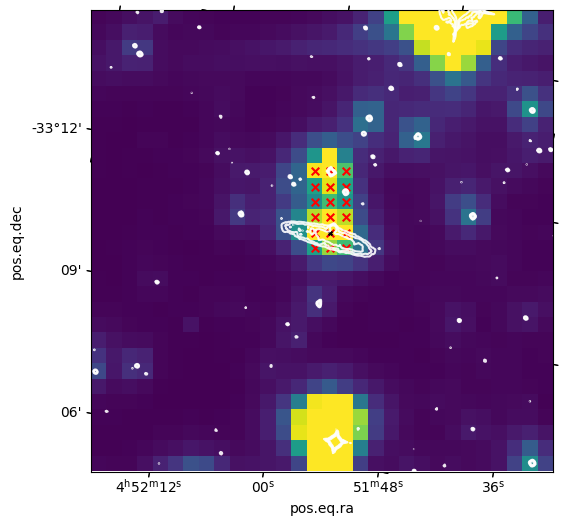

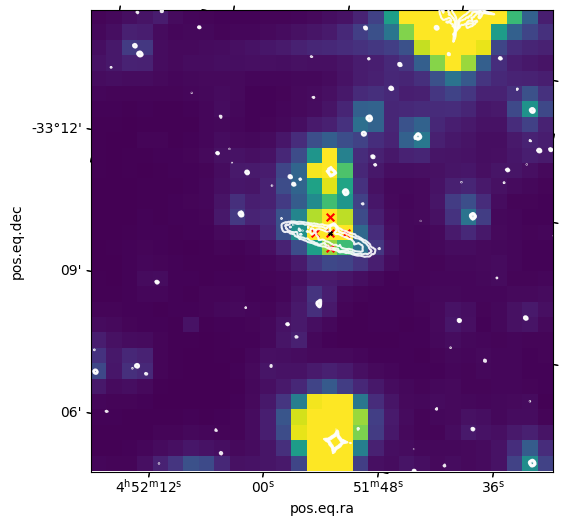

In [15]:
            for aperture in range(2):
                print(aperture)
                if aperture == 1:
                    row_col_coords_init = row_col_coords_diameter
                    row_col_coords = [(y, x) for x, y in row_col_coords_init]
                    aper = np.zeros(tpf[0].shape[1:], dtype=bool)
                    aper_mod = aper.copy() 
                    aper_buffer = aper.copy()
                    print('Now start on light curve from Simbad radius aperture')
                    if diameter == 0:
                        print('Could not find diameter! Skip.')
                        break
        #^^^
                #Plot the TPF image and the DSS contours together, to help with aperture selection, along with the starter aperture.
                if lowest_dss_contour == 0.4:
                    dss_levels = [0.4*dss_pixmax,0.5*dss_pixmax,0.75*dss_pixmax]
                elif lowest_dss_contour < 0.4:
                    dss_levels = [lowest_dss_contour*dss_pixmax,0.4*dss_pixmax,0.5*dss_pixmax,0.75*dss_pixmax]
                elif lowest_dss_contour > 0.4:
                    dss_levels = [lowest_dss_contour*dss_pixmax,0.65*dss_pixmax,0.85*dss_pixmax]
                fig = plt.figure(figsize=(6,6))
                ax = fig.add_subplot(111,projection=tpf_wcs)
                # ax.imshow(tpf.flux[200],vmin=pixmin,vmax=1e-3*pixmax+pixmean)
                ax.imshow(tpf.flux[plot_index].value,vmin=temp_min,vmax=temp_max)
                ax.contour(dss_image[0][0].data,transform=ax.get_transform(wcs_dss),levels=dss_levels,colors='white',alpha=0.9)
                for pixel in row_col_coords_init:
                    ax.scatter(pixel[0], pixel[1], marker='x', color='red', s=30)
                ax.scatter(aper_width/2.0,aper_width/2.0,marker='x',color='k',s=8)
                ax.set_xlim(-0.5,aper_width-0.5)  #This section is needed to fix the stupid plotting issue in Python 3.
                ax.set_ylim(-0.5,aper_width-0.5)
                directory = str(target).replace(" ","")   
                
    #            fig.canvas.mpl_disconnect(cid)
                buffer_pixels = [] #Define the buffer pixel region.
    
                if len(row_col_coords) == 0:
                    print('No mask selected; skipping this Sector.')
                else:
                    for i in range(0,len(row_col_coords)):
                        aper_mod[row_col_coords[i]] = True
                        row_same_up_column = (row_col_coords[i][0],row_col_coords[i][1]+1)
                        row_same_down_column = (row_col_coords[i][0],row_col_coords[i][1]-1)
                        column_same_down_row = (row_col_coords[i][0]-1,row_col_coords[i][1])
                        column_same_up_row = (row_col_coords[i][0]+1,row_col_coords[i][1])
                        bottom_left_corner = (row_col_coords[i][0]-1,row_col_coords[i][1]-1)
                        top_right_corner = (row_col_coords[i][0]+1,row_col_coords[i][1]+1)
                        top_left_corner = (row_col_coords[i][0]+1,row_col_coords[i][1]-1)
                        bottom_right_corner = (row_col_coords[i][0]-1,row_col_coords[i][1]+1)
                        buffer_line = (row_same_up_column,row_same_down_column,column_same_up_row,column_same_down_row,top_left_corner,top_right_corner,bottom_left_corner,bottom_right_corner)
                        buffer_pixels.append(buffer_line)
                        for coord_set in buffer_line:
                            aper_buffer[coord_set[0],coord_set[1]]=True
                print(aper_buffer)

In [2]:
                    #Create a mask that finds all of the bright, source-containing regions of the TPF.
                    allbright_mask = tpf.create_threshold_mask(threshold=bf_threshold,reference_pixel=None)
                    allfaint_mask = ~allbright_mask
                    allbright_mask &= ~aper_buffer
                    allfaint_mask &= ~aper_buffer
    
            #vvv                
                    tpf_orig = tpf
                    bkg_long_enough = True
                    reached_end = False
                    sys_threshold = sys_threshold_orig
                  
                    redo = True
                    additive_pca_num = 2
                    multiplicative_pca_num = 2
                    pca_only_num = 2
                    try:
                        while redo:
                            redo = False
    
                            while bkg_long_enough:
                                number_masked_regions = 0
                                tpf = tpf_orig
                                print('\nstarting from scratch')
                    #^^^
                                #Get the additive background first:
                                additive_hybrid_pcas = additive_pca_num
                                additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                    #DesignMatrix(tpf.flux[np.nonzero(tpf.flux)])
                                additive_bkg_and_constant = additive_bkg.append_constant()
                        #vvv
                                initial_bkg_length = len(additive_bkg.values)
                                print('initial bkg length:',initial_bkg_length)
                        #^^^
                                #Add a module to catch possible major systematics that need to be masked out before continuuing:
                                if np.max(np.abs(additive_bkg.values)) > sys_threshold:   #None of the normally extracted objects has additive components with absolute values over 0.2 ish.
                        #vvv
                                    masked_cadence_limits = []
                                    bkg_all = [[time[i] for time in additive_bkg.values] for i in range(additive_pca_num)]
                                    #masks = [findspiky(bkg) for bkg in bkg_all]
                                    #masks = [maskout_once(bkg) for bkg in bkg_all]
                                    masks = [maskout(bkg) for bkg in bkg_all]
                                    
                                        #replace values < 0 and > len(bkg)
                                    #masks = [[0 if y < 0 else len(bkg) if y > len(bkg) else y for y in s] if isinstance(s, list) else 0 if s < 0 else len(bkg) if s > len(bkg) else s for s in masks]
                                    #masks = [[[0 if cadence < 0 else length-1 if cadence >= length else cadence for cadence in mask] for mask in components] for components in masks]
                                    masks = [[[0 if cadence < 0 else length-1 if cadence >= length else cadence for cadence in mask] if isinstance(mask, list) else max(0, min(mask, length-1)) for mask in components] if isinstance(components, list) else max(0, min(components, length-1)) for components in masks]
                                    #print('masks:',masks)
                                    """if any(masks):
                                        allmasks = [item for sublist in masks for item in sublist]
                                        allmasks.sort(key=lambda interval: interval[0])
                                        intervals = [allmasks[0]]
                                        for mask in allmasks:
                                            previous = intervals[-1]
                                            if mask[0] <= previous[1]+1:
                                                previous[1] = max(previous[1], mask[1])
                                            else:
                                                 intervals.append(mask)
                                        masked_cadence_limits = intervals[0] #"""
                                    maskbegs = [lst[0] for lst in masks if lst]
                                    masked_cadence_limits = []
    
                                    if len(maskbegs) > 0: #""" if spiky or once
                                        masked_cadence_limits.append(min(maskbegs))
                                        intervals = sorted([interval for lst in masks if lst for interval in [lst[i:i+2] for i in range(0, len(lst), 2)]], key=lambda x: x[1])
                                        maskend = intervals[0][1]
                                        for i in range(1,additive_pca_num):
                                            if len(intervals) > i:
                                                if intervals[i][0] < maskend:
                                                     maskend = intervals[i][1]
                                        masked_cadence_limits.append(maskend)
                                        print('first masked region:',masked_cadence_limits)
                                        print('len(additive_bkg.values) =',len(additive_bkg.values)) #""" end if spiky or once
            #                        print(masked_cadence_limits)
            #                        np.savetxt('PCAs before mask.txt',bkg_all)
                        #^^^
                                       #if len(masked_cadence_limits) != 0:
                                        if masked_cadence_limits[0] >= 0:
                                            first_timestamp = tpf.time[masked_cadence_limits[0]].value
                                        else:
                                            first_timestamp = 0
                                        if masked_cadence_limits[1] < len(tpf.time) -1:
                                            last_timestamp = tpf.time[masked_cadence_limits[1]].value
                                        else:
                                            last_timestamp = tpf.time[-1].value
                                        cadence_mask = ~((tpf.time.value >= first_timestamp) & (tpf.time.value <= last_timestamp))
                                        tpf = tpf[cadence_mask]
                                        additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                        additive_bkg_and_constant = additive_bkg.append_constant()
            #                            print(np.max(np.abs(additive_bkg.values)))
    
                                    #vvv
                                        #for i in range(0,max_masked_regions):
                                        number_masked_regions = 1 #set to 1 at first, for this mask.
                                        while np.max(np.abs(additive_bkg.values)) > sys_threshold:
                                            """if len(intervals) == 1:
                                                reached_end = True
                                                break#""" #only one of the orincipal components has systematics left
            #                                print(np.max(np.abs(additive_bkg.values)))
    
                                            bkg_all = [[time[i] for time in additive_bkg.values] for i in range(additive_pca_num)]
                                            #print('masks:',masks)
                                            """for number_masked_regions in range(2,len(intervals)+1):
                                                masked_cadence_limits = intervals[number_masked_regions-1]""" #only for maskout one iteration (indent until if bkg_long_enough == False:)
                                            masked_cadence_limits = [] #only for maskout multiple iterations
                                            masks = [maskout(bkg) for bkg in bkg_all] #only for maskout multiple iterations
                                            print('masks:',masks)
                                            maskbegs = [lst[0] for lst in masks if lst] #""" if spiky or once
                                            if len(maskbegs) > 0:
                                                number_masked_regions += 1
            #                                    print('Systematics remain; define the next masked region.')
                                                masked_cadence_limits.append(min(maskbegs))
                                                intervals = sorted([interval for lst in masks if lst for interval in [lst[i:i+2] for i in range(0, len(lst), 2)]], key=lambda x: x[1])
                                                print('intervals:',intervals)
                                                maskend = intervals[0][1]
                                                for i in range(1,additive_pca_num):
                                                   if len(intervals) > i:
                                                        if intervals[i][0] < maskend:
                                                              maskend = intervals[i][1]
                                                masked_cadence_limits.append(maskend) #""" end if spiky or end (remove indent until if bkg_long_enough == False:)
                                    #^^^
                                                if masked_cadence_limits[0] >= 0:
                                                    first_timestamp = tpf.time[masked_cadence_limits[0]].value
                                                else:
                                                    first_timestamp = 0
                                                if masked_cadence_limits[1] < len(tpf.time) -1:
                                                    last_timestamp = tpf.time[masked_cadence_limits[1]].value
                                                else:
                                                    last_timestamp = tpf.time[-1].value
                                                cadence_mask = ~((tpf.time.value >= first_timestamp) & (tpf.time.value <= last_timestamp))
                                                tpf = tpf[cadence_mask]
                                                additive_bkg = DesignMatrix(tpf.flux[:, allfaint_mask]).pca(additive_hybrid_pcas)
                                                additive_bkg_and_constant = additive_bkg.append_constant()
    
                    #vvv
                                                if len(additive_bkg.values) < initial_bkg_length * min_bkg_length: #or number_masked_regions == max_masked_regions:
                                                    sys_threshold += increase_sys_threshold
                                                    if number_masked_regions == max_masked_regions:
                                                        print('reached limit of', number_masked_regions, 'masks')
                                                    else:
                                                        print('too many masks, additive_bkg is too short')
                                                    print('start again, new sys_threshold =',sys_threshold)
                                                    bkg_long_enough = False
                                                    break
    
                                                print('masked out',masked_cadence_limits)
                                                print('len(additive_bkg.values) =',len(additive_bkg.values),'/',initial_bkg_length)
                                            if bkg_long_enough == False:
                                                break
                                                """else:
                                                reached_end = True
                                                break#""" #only for maskout once?
                                                #number_masked_regions = max_masked_regions+10    #stops the loop if the user no longer wishes to add more regions.
                                        if np.max(np.abs(additive_bkg.values)) < sys_threshold:
                                            print('no more systematics above', sys_threshold, ', max:', np.max(np.abs(additive_bkg.values)))
                                            """elif reached_end == True:
                                            print('Reached end of first mask iteration')#""" #only if focus on iterations
                                        elif bkg_long_enough == False:
                                            bkg_long_enough = True
                                            continue #too many masks or additive_bkg too short
                                        else:
                                            print('Loop stopped without any condition being satisfied (?)')
                                     #else:
                                     #   print('(?) loop stopped: sys_threshold =',sys_threshold,', max =',np.max(np.abs(additive_bkg.values)),', masks =',masks)
                                bkg_long_enough = False
                                print('done with this sector')
                                print('max systematics:',np.max(np.abs(additive_bkg.values)))
                                print('masked out',number_masked_regions,'regions and',initial_bkg_length-len(additive_bkg.values),'of',initial_bkg_length,'timesteps \n')
            #                input('stop')        
                    #^^^
    
                            # Now we correct all the bright pixels EXCLUDING THE SOURCE by the background, so we can find the remaining multiplicative trend
                            r = RegressionCorrector(LightCurve(time=tpf.time, flux=tpf.time.value*0))
                            corrected_pixels = []
                            try:
                                for idx in range(allbright_mask.sum()):
                                    r.lc.flux = tpf.flux[:, allbright_mask][:, idx].value
                                    r.lc.flux_err = tpf.flux_err[:, allbright_mask][:, idx].value
                                        #lk warning appears if r.lc.flux_err consists of nans
                                    r.correct(additive_bkg_and_constant, propagate_errors=prop_error_flag)
                                    corrected_pixels.append(r.corrected_lc.flux)
                            except LinAlgError as e:
                                print('LinAlgError:',e)
                                print('skip this sector')
                                break
                            
                            #Getting the multiplicative effects now from the bright pixels.
                            multiplicative_hybrid_pcas = multiplicative_pca_num
                            multiplicative_bkg = DesignMatrix(np.asarray(corrected_pixels).T).pca(multiplicative_hybrid_pcas)
                            
                            #Create a design matrix using only the multiplicative components determined from the additively-corrected bright sources for simple hybrid method:
                            dm_mult = multiplicative_bkg
                            dm_mult = dm_mult.append_constant()
                            #Now get the raw light curve.
                            lc = tpf.to_lightcurve(aperture_mask=aper_mod)
                        #  lc = lc[lc.flux_err > 0]        #This was suggested by an error message to prevent the "flux uncertainties" problem.
                            median_flux_precorr = np.median(lc.flux.value) #Calculate the median flux before the background subtraction upcoming.
    
                            #Begin the SIMPLE HYBRID METHOD
                            #First, simple background subtraction to handle additive effects:
                            lc_bg = tpf.to_lightcurve(method='sap',corrector=None,aperture_mask = allfaint_mask)
                            num_pixels_faint = np.count_nonzero(allfaint_mask)
                            num_pixels_mask = np.count_nonzero(aper_mod)
                            percent_of_bg_in_src = num_pixels_mask / num_pixels_faint
                            lc_bg_time = lc_bg.time.value
                            lc_bg_flux = lc_bg.flux.value
                            lc_bg_fluxerr = lc_bg.flux_err.value
                            lc_bg_scaled = lc_bg_flux - (1-percent_of_bg_in_src)*lc_bg_flux
                            lc.flux = lc.flux.value - lc_bg_scaled
    
                            #Replace any errors that are zero or negative with the mean error:
                            mean_error = np.mean(lc.flux_err[np.isfinite(lc.flux_err)])
                            lc.flux_err = np.where(lc.flux_err == 0,mean_error,lc.flux_err)
                            lc.flux_err = np.where(lc.flux_err < 0,mean_error,lc.flux_err)
                            lc.flux_err = lc.flux_err.value
    
                            #And correct regressively for the multiplicative effects in the simple hybrid method:
                            corrector_1 = RegressionCorrector(lc)
                            clc = corrector_1.correct(dm_mult,propagate_errors=prop_error_flag)
    
                            #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                            corrector_1.original_lc = corrector_1.lc
                            sh_overfit_metric = corrector_1.compute_overfit_metric()
                            #sh_underfit_metric = corrector_1.compute_underfit_metric() #Has to wait until we make our own using quaver-derived light curves of nearby targets.
    
                            #The background subtraction can sometimes cause fluxes below the source's median
                            #to be slightly negative; this enforces a minimum of zero, but can be ignored.
                            if np.min(clc.flux.value) < 0:
                                dist_to_zero = np.abs(np.min(clc.flux.value))
                                clc.flux = clc.flux.value + dist_to_zero
    
                            # Optional additive correction back to original median:
                            median_flux_postsub = np.median(clc.flux.value)
                            additive_rescale_factor = median_flux_precorr - median_flux_postsub
                            #clc.flux = clc.flux.value + additive_rescale_factor    #uncomment if you want to use this.
                            var_amplitude = np.max(clc.flux.value) - np.min(clc.flux.value)
                            percent_variability = (var_amplitude / median_flux_precorr)*100
    
                            #For the FULL HYBRID METHOD:
                            #We make a fancy hybrid design matrix collection that has two orders of the additive effects, and the multiplicative effects.
                            additive_bkg_squared = deepcopy(additive_bkg)
                            additive_bkg_squared.df = additive_bkg_squared.df**2
                            dmc = DesignMatrixCollection([additive_bkg_and_constant, additive_bkg_squared, multiplicative_bkg])
                            lc_full = tpf.to_lightcurve(aperture_mask=aper_mod)
                            r2 = RegressionCorrector(lc_full)
                            r2.lc.flux = lc_full.flux.value
                            r2.lc.flux_err = lc_full.flux_err.value
                            clc_full = r2.correct(dmc,propagate_errors=prop_error_flag)
    
                            #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                            r2.original_lc = r2.lc
                            fh_overfit_metric = r2.compute_overfit_metric()
                            #fh_underfit_metric = r2.compute_underfit_metric()  #Has to wait until we make our own using quaver-derived light curves of nearby targets.
                            #clc_full = RegressionCorrector(lc_full).correct(dmc,propagate_errors=prop_error_flag)
                    #vvv
                            if additive_pca_num == 2 and fh_overfit_metric > 0.8:
                                print('No overfitting (fh_overfit_metric =',fh_overfit_metric,'), try three PCA parameters')
                                additive_pca_num = 3
                                multiplicative_pca_num = 3
                                pca_only_num = 3
                                redo = True
                                bkg_long_enough = True
                                tpf = tpf_orig
                                reached_end = False
                                sys_threshold = sys_threshold_orig
                                continue #continues the while loop, i.e. same sector but with 3 PCs 
                    #^^^
    
                            #Now we begin the SIMPLE PCA METHOD with components of all non-source pixels.
                            raw_lc_OF = tpf.to_lightcurve(aperture_mask=aper_mod)
                            #Replace any errors that are zero or negative with the mean error:
                            raw_lc_OF.flux_err = np.where(raw_lc_OF.flux_err == 0,mean_error,raw_lc_OF.flux_err)
                            raw_lc_OF.flux_err = np.where(raw_lc_OF.flux_err < 0,mean_error,raw_lc_OF.flux_err)
                            raw_lc_OF.flux_err = np.where(np.isnan(raw_lc_OF.flux_err)==True,mean_error,raw_lc_OF.flux_err)
                        #    raw_lc_OF = raw_lc_OF[raw_lc_OF.flux_err > 0]   #This was suggested by an error message to prevent the "flux uncertainties" problem.
                            regressors_OF = tpf.flux[:,~aper_mod]
                            number_of_pcas = pca_only_num
                            dm_OF = DesignMatrix(regressors_OF,name='regressors')
                            dm_pca_OF = dm_OF.pca(pca_only_num)
                            dm_pca_OF = dm_pca_OF.append_constant()
                            r3 = RegressionCorrector(raw_lc_OF)
                            r3.lc.flux = raw_lc_OF.flux.value
                            r3.lc.flux_err = raw_lc_OF.flux_err.value
                            corrected_lc_pca_OF = r3.correct(dm_pca_OF,propagate_errors=prop_error_flag)
    
                            #Compute over- and under-fitting metrics using Lightkurve's lombscargle and neighbors methods:
                            r3.original_lc = r3.lc
                            pca_overfit_metric = r3.compute_overfit_metric()
                            #pca_underfit_metric = r3.compute_underfit_metric()  #Has to wait until we make our own using quaver-derived light curves of nearby targets.
    
                    #vvv
                            #clean light curve from systematics
                            start = starts[int(sec)-1]
                            end = ends[int(sec)-1]
                            downlink = downlinks[int(sec)-1]
                            for a in range(3): #3 for all three methods
                                method = methods[a]
                                if method == "PCA":
                                    time = corrected_lc_pca_OF.time.value
                                    flux = corrected_lc_pca_OF.flux.value
                                if method == 'simple_hybrid':
                                    time = clc.time.value
                                    flux = clc.flux.value
                                if method == 'full_hybrid':
                                    time = clc_full.time.value
                                    flux = clc_full.flux.value
                                    
                                sorted_flux = np.sort(flux)
                                delete_indices = int(len(sorted_flux) * sys_percentile / 100)
                                sorted_flux = sorted_flux[delete_indices:len(sorted_flux)-delete_indices]
                                #std = np.std(sorted_flux)
                                medianflux = np.median(sorted_flux)
                                diff_from_median = [abs(f - medianflux) for f in sorted_flux]
                                mdfm = np.median(diff_from_median)
                                ppm = np.std(flux) / np.mean(flux) * 1000000
                                remove, removefirst, also_remove, alsoalso_remove, removeremove, singleremove = [], [], [], [], [], []
                                
                                #remove fluxes near downlinks or orbit starts/ends
                                for timeind,timestep in enumerate(time):
                                    if timestep - start < cut_orbit or end - timestep < cut_orbit or abs(timestep - downlink) < cut_downlink:
                                        removefirst.append(timeind)
                                """if 75 >= float(sec) >= 56:
                                    dl1 = dls1[int(sec)-56]
                                    dl2 = dls2[int(sec)-56]
                                    for timeind,timestep in enumerate(time):
                                        if abs(timestep - dl1) < cut_downlink_extra or abs(timestep - dl2) < cut_downlink_extra:
                                            removefirst.append(timeind) #"""
                                
                                for index,thisflux in enumerate(flux):
                                    #remove negative fluxes
                                    if thisflux <= 0:
                                        remove.append(index)
                                    #remove if flux is more than threshold above median
                                #    elif abs(thisflux / medianflux - 1) > percent/100:
                                #    elif abs(thisflux - medianflux) > std * stddevs:
                                    elif abs(thisflux - medianflux) > mdfm * mdfm_distance:
                                        remove.append(index)
                                remove.sort()
                                
                                #don't remove statistical single-cadence outliers
                                if len(remove) == 1:
                                    if abs(flux[remove[0]] - medianflux) < mdfm * mdfm_distance * outlier_factor:
                                        remove = []
                                    elif remove[0] != 0 and remove[0] != len(flux)-1 and \
                                    abs(flux[remove[0]-1] - medianflux) < mdfm * mdfm_distance / outlier_factor and \
                                    abs(flux[remove[0]+1] - medianflux) < mdfm * mdfm_distance / outlier_factor:
                                        singleremove.append(remove[0])    
                                elif len(remove) > 1:
                                    if abs(time[remove[0]] - time[remove[1]]) > outlier_time:
                                        if abs(flux[remove[0]] - medianflux) < mdfm * mdfm_distance * outlier_factor:
                                            removeremove.append(remove[0])
                                        elif remove[0] != 0 and abs(flux[remove[0]-1] - medianflux) < mdfm * mdfm_distance / outlier_factor \
                                        and abs(flux[remove[0]+1] - medianflux) < mdfm * mdfm_distance / outlier_factor:
                                            singleremove.append(remove[0])
                                    if abs(time[remove[-1]] - time[remove[-2]]) > outlier_time:
                                        if abs(flux[remove[-1]] - medianflux) < mdfm * mdfm_distance * outlier_factor:
                                            removeremove.append(remove[-1])
                                        elif remove[-1] != len(flux)-1 and abs(flux[remove[-1]-1] - medianflux) < mdfm * mdfm_distance / outlier_factor \
                                        and abs(flux[remove[-1]+1] - medianflux) < mdfm * mdfm_distance / outlier_factor:
                                            singleremove.append(remove[-1])
                                    for i,index in enumerate(remove[1:-1]):
                                        if abs(time[index] - time[remove[i-1]]) > outlier_time and abs(time[index] - time[remove[i+1]]) < outlier_time:
                                            if abs(flux[index] - medianflux) < mdfm * mdfm_distance * outlier_factor:
                                                removeremove.append(index)
                                            elif abs(flux[index-1] - medianflux) < mdfm * mdfm_distance / outlier_factor \
                                            and abs(flux[index+1] - medianflux) < mdfm * mdfm_distance / outlier_factor:
                                                singleremove.append(index) 
                                remove = [x for x in remove if x not in removeremove and x not in singleremove]
                                
                                #remove indices less than threshold between systematics
                                for index,timeindex in enumerate(remove[:-1]):
                                    if not timeindex+1 in remove:
                                        if time[remove[index+1]] - time[timeindex] < min_day_between_sys:
                                            also_remove.extend(i for i in range(timeindex+1, remove[index+1]))
                                if len(remove) > 0:
                                    if time[remove[0]] - time[0] < min_day_between_sys:
                                        also_remove.extend(i for i in range(0, remove[0]))
                                    if time[-1] - time[remove[-1]] < min_day_between_sys:
                                        also_remove.extend(i for i in range(remove[-1]+1, len(time)))
                                remove = remove + also_remove
                                
                                #remove desired times before and after beginning and end
                                if len(remove) > 0:
                                    for index in remove:
                                        if not index-1 in remove:
                                            if abs(time[index] - time[0]) < buffer_hours/24:
                                                alsoalso_remove.extend(i for i in range(0, index))
                                            else:
                                                for prevsteps,prevtimes in enumerate(reversed(time[index-buffer_hours*20:index])):
                                                    if abs(time[index] - prevtimes) < buffer_hours/24:
                                                        alsoalso_remove.append(index-prevsteps-1)
                                        if not index+1 in remove:
                                            if abs(time[-1] - time[index]) < buffer_hours/24:
                                                alsoalso_remove.extend(i for i in range(index+1, len(time)))
                                            else:
                                                for nextsteps,nexttimes in enumerate(time[index+1:index+buffer_hours*20]):
                                                    if abs(nexttimes - time[index]) < buffer_hours/24:
                                                        alsoalso_remove.append(index+nextsteps+1)
                                removeall = removefirst + remove + alsoalso_remove + singleremove
                                removeall[:] = list(set(removeall))
                                
                                #remove from light curve
                                fluxnew = [j for i, j in enumerate(flux) if i not in removeall]
                                timenew = [j for i, j in enumerate(time) if i not in removeall]
                                ppm2 = np.std(fluxnew) / np.mean(fluxnew) * 1000000
                                datanew = Table([timenew, fluxnew], names=('time', 'flux'))
                                if aperture == 0:
                                    datanew.write('quaver_output/'+target_safename+'/'+target_safename+'_sector'+sec+'_'+method+'_lc_cleaned.fits', overwrite=True, format='fits')
                                else:
                                    datanew.write('quaver_output/'+target_safename+'/'+target_safename+'_sector'+sec+'_'+method+'_lc_diameter_cleaned.fits', overwrite=True, format='fits')
                                print('\n',method)
                                print('removed',len(removeall),'cadences')
                                print('CoD before:', ppm,'\t after:',ppm2)
                    #^^^
    
                            #AND PLOT THE CORRECTED LIGHT CURVE.
                            fig2 = plt.figure(figsize=(12,8))
                            gs = gridspec.GridSpec(ncols=3, nrows=3,wspace=0.5,hspace=0.5,width_ratios=[1,1,2])
                            f_ax1 = fig2.add_subplot(gs[0, :])
                            f_ax1.set_title(target+': Corrected Light Curve')
                            f_ax2 = fig2.add_subplot(gs[1, :-1])
                            if primary_correction_method == 1:
                                f_ax2.set_title('Principal Components')
                                f_ax4 = fig2.add_subplot(gs[1:,-1])
                            elif primary_correction_method == 2 or primary_correction_method == 3:
                                f_ax2.set_title('Additive Components')
                                f_ax3 = fig2.add_subplot(gs[2:,:-1])
                                f_ax3.set_title('Multiplicative Components')
                                f_ax4 = fig2.add_subplot(gs[1:,-1])
    
                            if primary_correction_method == 1:
                                corrected_lc_pca_OF.plot(ax=f_ax1)
                            elif primary_correction_method == 2:
                                clc.plot(ax=f_ax1)
                            elif primary_correction_method == 3:
                                clc_full.plot(ax=f_ax1)
                            if primary_correction_method == 1:
                                f_ax2.plot(raw_lc_OF.time.value,dm_pca_OF.values[:,0:-1])
                            elif primary_correction_method == 2 or primary_correction_method == 3:
                                f_ax2.plot(raw_lc_OF.time.value,additive_bkg.values)
                                f_ax3.plot(raw_lc_OF.time.value,multiplicative_bkg.values + np.arange(multiplicative_bkg.values.shape[1]) * 0.3)
                            tpf.plot(ax=f_ax4,aperture_mask=aper_mod,title='Aperture')